# CMSC320 Final Project: Predicting future rent prices in the DMV (D.C., Maryland, and Virginia) Metropolitan Area

## Imports

In [2]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np
import openpyxl

## Data Cleaning

In [3]:
dfs = {}

# 1. download small area fmrs from 2015 to 2021
# 2. 2025 - 2022: MODEL DF
# 3. 2021, 2019: Aadi
# 4. 2020: Jay
# 5: 2018 - 2015: Jay

In [4]:
# 2019, 2021
for i in range(2019, 2022):
    if i == 2020:
        continue
    
    df = pd.read_excel(f'datasets/fmrs_{i}.xlsx')
    df = df[df['HUD Metro Fair Market Rent Area Name'] == 'Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area']
    df = df.drop(df.columns[[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17]], axis=1)
    df = df.reset_index(drop=True)
    
    df = df.rename(columns={
            'ZIP\nCode': 'zip_code',
            'SAFMR\n0BR': '0_bedroom',
            'SAFMR\n1BR': '1_bedroom',
            'SAFMR\n2BR': '2_bedroom',
            'SAFMR\n3BR': '3_bedroom',
            'SAFMR\n4BR': '4_bedroom'
        })
    
    df = df[df['zip_code'] != 88888]
    
    dfs[i] = df

In [5]:
for i in range(2022, 2026):
    df = pd.read_excel(f'datasets/fmrs_{i}.xlsx')
    df = df[df['HUD Metro Fair Market Rent Area Name'] == 'Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area']
    df = df.drop(df.columns[[0, 1]], axis=1)
    df = df.reset_index(drop=True)
    
    df = df.rename(columns={
            'ZIP\nCode': 'zip_code',
            'erap_fmr_br0': '0_bedroom',
            'erap_fmr_br1': '1_bedroom',
            'erap_fmr_br2': '2_bedroom',
            'erap_fmr_br3': '3_bedroom',
            'erap_fmr_br4': '4_bedroom'
        })
    
    df = df[df['zip_code'] != 88888]
    
    dfs[i] = df

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [6]:
df_2020 = pd.read_excel('data/fy2020_safmrs_rev.xlsx')
df_2020

,zcta,CBSASub20,Areaname20,safmr_0br,safmr_0br_90pct_pay_std,safmr_0br_110pct_pay_std,safmr_1br,safmr_1br_90pct_pay_std,safmr_1br_110pct_pay_std,safmr_2br,safmr_2br_90pct_pay_std,safmr_2br_110pct_pay_std,safmr_3br,safmr_3br_90pct_pay_std,safmr_3br_110pct_pay_std,safmr_4br,safmr_4br_90pct_pay_std,safmr_4br_110pct_pay_std
0,76437,METRO10180M10180,"Abilene, TX MSA",540,486,594,560,504,616,740,666,814,960,864,1056,1240,1116,1364
1,76443,METRO10180M10180,"Abilene, TX MSA",540,486,594,560,504,616,740,666,814,960,864,1056,1240,1116,1364
2,76464,METRO10180M10180,"Abilene, TX MSA",540,486,594,560,504,616,740,666,814,960,864,1056,1240,1116,1364
3,76469,METRO10180M10180,"Abilene, TX MSA",550,495,605,580,522,638,760,684,836,1000,900,1100,1290,1161,1419
4,79501,METRO10180M10180,"Abilene, TX MSA",670,603,737,690,621,759,910,819,1001,1200,1080,1320,1540,1386,1694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26085,85356,METRO49740M49740,"Yuma, AZ MSA",550,495,605,590,531,649,780,702,858,1130,1017,1243,1370,1233,1507
26086,85364,METRO49740M49740,"Yuma, AZ MSA",600,540,660,650,585,715,860,774,946,1240,1116,1364,1510,1359,1661
26087,85365,METRO49740M49740,"Yuma, AZ MSA",660,594,726,720,648,792,940,846,1034,1360,1224,1496,1650,1485,1815
26088,85366,METRO49740M49740,"Yuma, AZ MSA",570,513,627,620,558,682,820,738,902,1180,1062,1298,1440,1296,1584


In [7]:
df_2020 = df_2020[df_2020['Areaname20'] == 'Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area']
df_2020 = df_2020.rename(columns={
        'zcta' : 'zip_code',
        'safmr_0br': '0_bedroom',
        'safmr_1br': '1_bedroom',
        'safmr_2br': '2_bedroom',
        'safmr_3br': '3_bedroom',
        'safmr_4br': '4_bedroom'
    })
df_2020 = df_2020.drop(['CBSASub20', 'Areaname20', 'safmr_0br_90pct_pay_std', 'safmr_0br_110pct_pay_std','safmr_1br_90pct_pay_std',  'safmr_1br_110pct_pay_std', 'safmr_2br_90pct_pay_std',  'safmr_2br_110pct_pay_std', 'safmr_3br_90pct_pay_std', 'safmr_3br_110pct_pay_std', 'safmr_4br_90pct_pay_std', 'safmr_4br_110pct_pay_std'], axis=1)
df_2020 = df_2020[df_2020['zip_code'] != 88888]
df_2020 = df_2020.reset_index(drop = True)
df_2020
dfs[2020] = df_2020


In [8]:
zip_codes = pd.read_csv('data/zip_code_database.csv')
zip_codes = zip_codes[zip_codes['state'].isin(['MD', 'VA', 'DC'])]
zip_codes 

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
8278,20001,STANDARD,0,Washington,NaN,NaN,DC,District of Columbia,America/New_York,"202, 771",NaN,US,38.91,-77.02,33910
8279,20002,STANDARD,0,Washington,NaN,NaN,DC,District of Columbia,America/New_York,"202, 771",NaN,US,38.91,-76.98,53730
8280,20003,STANDARD,0,Washington,NaN,NaN,DC,District of Columbia,America/New_York,"202, 771",NaN,US,38.88,-76.99,29800
8281,20004,STANDARD,0,Washington,NaN,NaN,DC,District of Columbia,America/New_York,"202, 771",NaN,US,38.90,-77.03,1170
8282,20005,STANDARD,0,Washington,NaN,NaN,DC,District of Columbia,America/New_York,"202, 771",NaN,US,38.90,-77.03,8310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25201,56984,UNIQUE,0,Parcel Return Service,Prs,Parcel Return Svc,DC,NaN,America/New_York,NaN,NaN,US,0.00,0.00,0
25202,56985,UNIQUE,0,Parcel Return Service,Prs,Parcel Return Svc,DC,NaN,America/New_York,NaN,NaN,US,0.00,0.00,0
25203,56998,UNIQUE,0,Parcel Return Service,Prs,Parcel Return Svc,DC,NaN,America/New_York,"202, 771",NaN,US,38.89,-77.03,0
25204,56999,UNIQUE,0,Parcel Return Service,Prs,Parcel Return Svc,DC,NaN,America/New_York,"202, 771",NaN,US,38.89,-77.03,0


In [9]:
df_2018 = pd.read_excel('data/FY18_4050_FMRs_rev.xlsx')
df_2018 = df_2018[df_2018['areaname'] == 'Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area']

zip_codes['county'] = zip_codes['county'].str.strip().str.lower()
df_2018['countyname'] = df_2018['countyname'].str.strip().str.lower()

df_2018 = zip_codes[
    zip_codes['county'].notna() & zip_codes['county'].isin(df_2018['countyname'])
].merge(
    df_2018[['countyname', 'fmr_0', 'fmr_1', 'fmr_2', 'fmr_3', 'fmr_4']],
    left_on='county',
    right_on='countyname',
    how='left'
)[['zip', 'fmr_0', 'fmr_1', 'fmr_2', 'fmr_3', 'fmr_4']]
df_2018 = df_2018.rename(columns={
        'zip' : 'zip_code',
        'fmr_0': '0_bedroom',
        'fmr_1': '1_bedroom',
        'fmr_2': '2_bedroom',
        'fmr_3': '3_bedroom',
        'fmr_4': '4_bedroom'
    })

dfs[2018] = df_2018

In [10]:
df_2017 = pd.read_excel('data/FY2017-4050-County-Level_Data.xlsx')
df_2017 = df_2017[df_2017['areaname'] == 'Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area']

zip_codes['county'] = zip_codes['county'].str.strip().str.lower()
df_2017['countyname'] = df_2017['countyname'].str.strip().str.lower()

df_2017 = zip_codes[
    zip_codes['county'].notna() & zip_codes['county'].isin(df_2017['countyname'])
].merge(
    df_2017[['countyname', 'fmr0', 'fmr1', 'fmr2', 'fmr3', 'fmr4']],
    left_on='county',
    right_on='countyname',
    how='left'
)[['zip', 'fmr0', 'fmr1', 'fmr2', 'fmr3', 'fmr4']]
df_2017 = df_2017.rename(columns={
        'zip' : 'zip_code',
        'fmr0': '0_bedroom',
        'fmr1': '1_bedroom',
        'fmr2': '2_bedroom',
        'fmr3': '3_bedroom',
        'fmr4': '4_bedroom'
    })
dfs[2017] = df_2017

In [11]:
# df_2022 = dfs[2022]
# df_2020 = dfs[2020]

# df_2022 = df_2022[~df_2022['zip_code'].isin(df_2020['zip_code'])]
# df_2022
# zip_codes = zip_codes[zip_codes['zip'].isin(df_2022['zip_code'])]
# zip_codes.to_csv('testzip.csv')

In [12]:
#Used 2020 as reference since it was the most recent year with 443 zip codes. 
df_2020 = dfs[2020]
for df in dfs:
    df_curr = dfs[df]
    df_curr = df_curr[df_curr['zip_code'].isin(df_2020['zip_code'])]
    dfs[df] = df_curr
    print(df)
    display(dfs[df])
    # Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area
    # Washington-Arlington-Alexandria, DC-VA-MD HUD Metro FMR Area

2019


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,1740,1790,2050,2680,3300
1,20002,1220,1260,1440,1880,2320
2,20003,2120,2180,2500,3270,4020
3,20004,2120,2180,2500,3270,4020
4,20005,2000,2050,2350,3070,3780
...,...,...,...,...,...,...
438,22742,1170,1230,1420,1870,2320
439,22960,1170,1230,1420,1870,2320
440,23015,1170,1230,1420,1870,2320
441,23024,1170,1230,1420,1870,2320


2021


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,2080,2130,2430,3120,3780
1,20002,1330,1360,1550,1990,2410
2,20003,2270,2320,2650,3400,4120
3,20004,2270,2320,2650,3400,4120
4,20005,2160,2210,2520,3230,3910
...,...,...,...,...,...,...
500,22742,1130,1160,1320,1690,2050
501,22960,960,1000,1160,1530,1890
502,23015,960,1000,1160,1530,1890
503,23024,960,1000,1160,1530,1890


2022


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,2180,2220,2530,3200,3840
1,20002,1539,1567,1785,2260,2713
2,20003,2310,2350,2680,3390,4070
3,20004,2310,2350,2680,3390,4070
4,20005,2210,2250,2560,3240,3890
...,...,...,...,...,...,...
500,22742,1539,1567,1785,2260,2713
501,22960,1539,1567,1785,2260,2713
502,23015,1539,1567,1785,2260,2713
503,23024,1539,1567,1785,2260,2713


2023


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,2300,2340,2660,3330,3970
1,20002,1589,1615,1838,2299,2742
2,20003,2390,2430,2760,3450,4120
3,20004,2390,2430,2760,3450,4120
4,20005,2200,2240,2550,3190,3800
...,...,...,...,...,...,...
499,22742,1589,1615,1838,2299,2742
500,22960,1589,1615,1838,2299,2742
501,23015,1589,1615,1838,2299,2742
502,23024,1589,1615,1838,2299,2742


2024


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,2460,2500,2840,3530,4190
1,20002,1772,1803,2045,2544,3015
2,20003,2660,2710,3070,3820,4530
3,20004,2610,2650,3010,3740,4440
4,20005,2330,2370,2690,3350,3970
...,...,...,...,...,...,...
500,22742,1772,1803,2045,2544,3015
501,22960,1772,1803,2045,2544,3015
502,23015,1772,1803,2045,2544,3015
503,23024,1772,1803,2045,2544,3015


2025


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,2770,2830,3190,3990,4700
1,20002,2050,2100,2360,2950,3480
2,20003,3020,3080,3470,4340,5120
3,20004,2900,2960,3330,4160,4910
4,20005,2520,2580,2900,3630,4280
...,...,...,...,...,...,...
500,22742,2012,2056,2314,2893,3413
501,22960,2012,2056,2314,2893,3413
502,23015,2012,2056,2314,2893,3413
503,23024,2012,2056,2314,2893,3413


2020


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,1890,1950,2220,2880,3520
1,20002,1280,1320,1500,1950,2380
2,20003,2190,2250,2560,3320,4060
3,20004,2190,2250,2560,3320,4060
4,20005,2070,2130,2430,3150,3850
...,...,...,...,...,...,...
438,22742,1060,1110,1280,1690,2090
439,22960,1060,1110,1280,1690,2090
440,23015,1060,1110,1280,1690,2090
441,23024,1060,1110,1280,1690,2090


2018


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,1504,1561,1793,2353,2902
1,20002,1504,1561,1793,2353,2902
2,20003,1504,1561,1793,2353,2902
3,20004,1504,1561,1793,2353,2902
4,20005,1504,1561,1793,2353,2902
...,...,...,...,...,...,...
736,22712,1504,1561,1793,2353,2902
737,22720,1504,1561,1793,2353,2902
738,22728,1504,1561,1793,2353,2902
739,22734,1504,1561,1793,2353,2902


2017


,zip_code,0_bedroom,1_bedroom,2_bedroom,3_bedroom,4_bedroom
0,20001,1440,1513,1746,2300,2855
1,20002,1440,1513,1746,2300,2855
2,20003,1440,1513,1746,2300,2855
3,20004,1440,1513,1746,2300,2855
4,20005,1440,1513,1746,2300,2855
...,...,...,...,...,...,...
736,22712,1440,1513,1746,2300,2855
737,22720,1440,1513,1746,2300,2855
738,22728,1440,1513,1746,2300,2855
739,22734,1440,1513,1746,2300,2855


## 3 Statistical Methods (Hypothesis Tests)

### Default assumptions
1. $\alpha$ (critical value) = 0.05

### Hypothesis test #1

$H_0:$ There is no difference in average one bedroom rent prices for all the years

$H_a:$ There is a difference in average one bedroom rent prices for at least one of the years

0.0


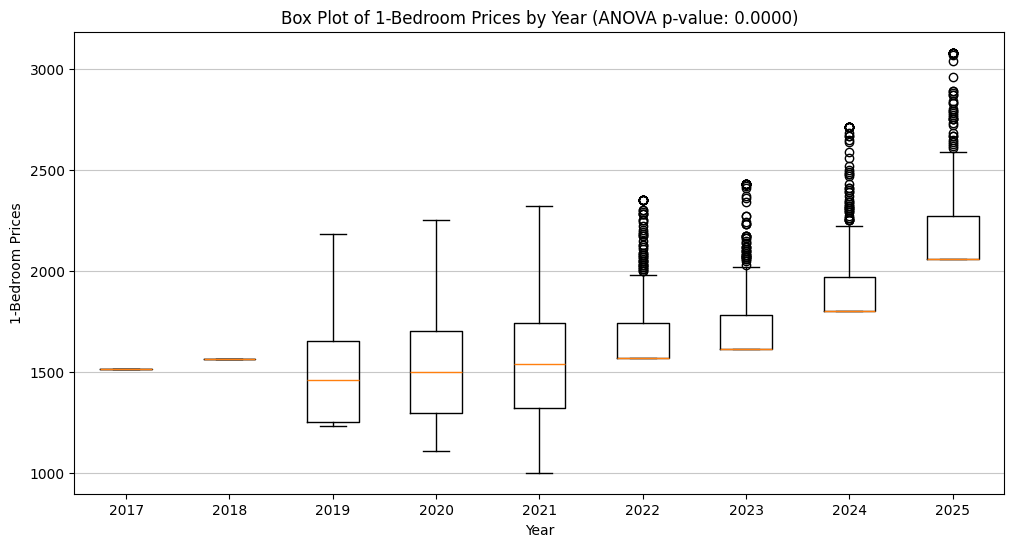

In [13]:
# Test: ANOVA

samples = []

for year in range(2017, 2026):
    df = dfs[year]
    samples.append(df['1_bedroom'])


res = stats.f_oneway(*samples)
pvalue = res.pvalue
print(pvalue)

plt.figure(figsize=(12, 6))
plt.boxplot(samples)
    
plt.xticks(range(1, len(samples) + 1), [f'{year}' for year in range(2017, 2026)])
plt.xlabel('Year')
plt.ylabel('1-Bedroom Prices')
plt.title('Box Plot of 1-Bedroom Prices by Year (ANOVA p-value: {:.4f})'.format(pvalue))

plt.grid(axis='y', alpha=0.7)
plt.show()

Conclusion: Since the p-value (0.0) < $\alpha$ (0.05), we reject $H_0$. There is enough evidence to suggest that $H_a$ is true, meaning that at least one of the years has a different average one bedroom rent prices compared to all the other years

### Hypothesis test #2

Since from the first test we used ANOVA to conclude there is at least one different group, we can use a Post-Hoc test to find out which group is different

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -48.000     0.068   -97.732     1.732
 (0 - 2)      2.729     1.000   -46.381    51.839
 (0 - 3)    -20.093     0.940   -69.203    29.018
 (0 - 4)    -47.429     0.068   -96.539     1.681
 (0 - 5)   -182.928     0.000  -232.065  -133.790
 (0 - 6)   -226.717     0.000  -275.854  -177.580
 (0 - 7)   -425.226     0.000  -474.364  -376.089
 (0 - 8)   -693.204     0.000  -742.341  -644.066
 (1 - 0)     48.000     0.068    -1.732    97.732
 (1 - 2)     50.729     0.037     1.619    99.839
 (1 - 3)     27.907     0.706   -21.203    77.018
 (1 - 4)      0.571     1.000   -48.539    49.681
 (1 - 5)   -134.928     0.000  -184.065   -85.790
 (1 - 6)   -178.717     0.000  -227.854  -129.580
 (1 - 7)   -377.226     0.000  -426.364  -328.089
 (1 - 8)   -645.204     0.000  -694.341  -596.066
 (2 - 0)     -2.729     1.000   -51.839    46.381
 (2 - 1)    -50.729     0.037   

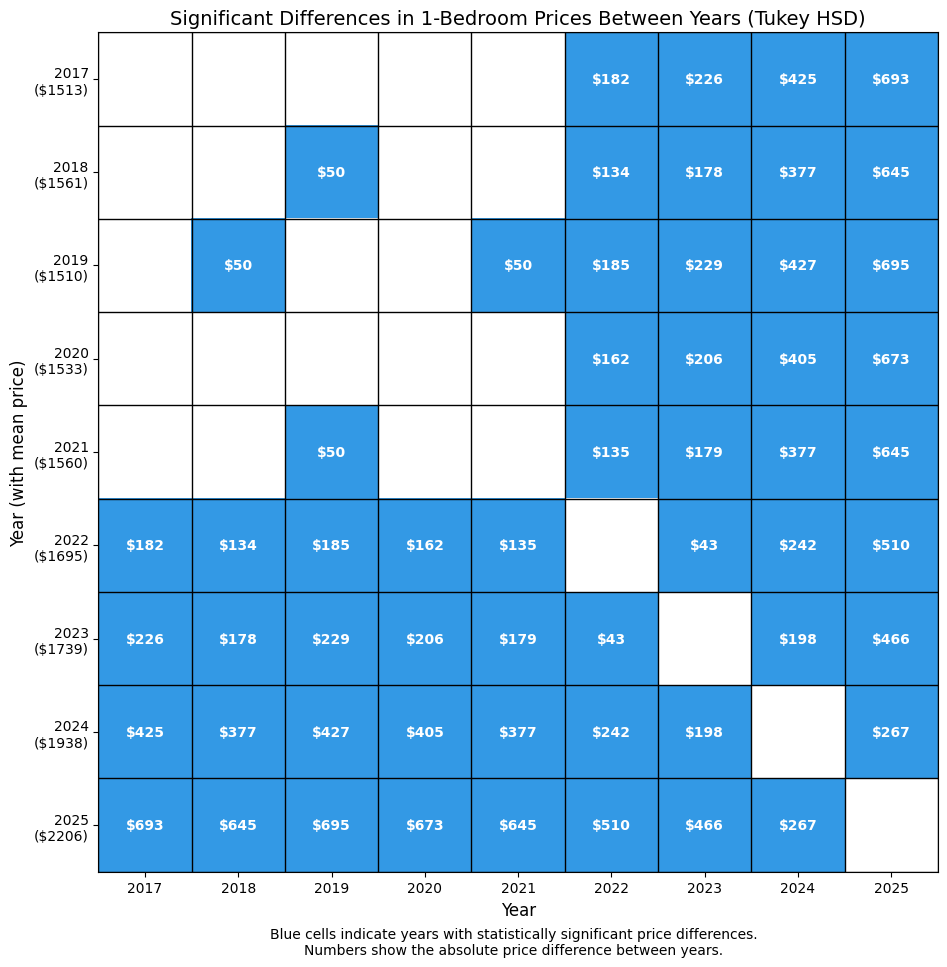

In [ ]:
res = stats.tukey_hsd(*samples)

print(res)

years = list(range(2017, 2026))
n_years = len(years)
significance_matrix = np.zeros((n_years, n_years))

significant_pairs = {
    2017: [2022, 2023, 2024, 2025],
    2018: [2019, 2022, 2023, 2024, 2025],
    2019: [2018, 2021, 2022, 2023, 2024, 2025],
    2020: [2022, 2023, 2024, 2025],
    2021: [2019, 2022, 2023, 2024, 2025],
    2022: [2017, 2018, 2019, 2020, 2021, 2023, 2024, 2025],
    2023: [2017, 2018, 2019, 2020, 2021, 2022, 2024, 2025],
    2024: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2025],
    2025: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
}

for i, year1 in enumerate(years):
    for year2 in significant_pairs.get(year1, []):
        j = years.index(year2)
        significance_matrix[i, j] = 1

means = [np.mean(sample) for sample in samples]

fig, ax = plt.subplots(figsize=(12, 10))

colors = [(1, 1, 1), (0.2, 0.6, 0.9)]  
cmap = pltcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=2)

im = ax.imshow(significance_matrix, cmap=cmap, vmin=0, vmax=1)

for i in range(n_years + 1):
    ax.axhline(i - 0.5, color='black', linewidth=1)
    ax.axvline(i - 0.5, color='black', linewidth=1)

ax.set_xticks(range(n_years))
ax.set_yticks(range(n_years))
ax.set_xticklabels(years)
ax.set_yticklabels([f"{year}\n(${int(mean)})" for year, mean in zip(years, means)])

for i in range(n_years):
    for j in range(n_years):
        if significance_matrix[i, j] == 1:
            diff = means[i] - means[j]
            diff_text = f"${int(abs(diff))}"
            
            ax.text(j, i, diff_text, 
                   ha="center", va="center", 
                   color="white" if significance_matrix[i, j] else "black",
                   fontweight='bold')

plt.title("Significant Differences in 1-Bedroom Prices Between Years (Tukey HSD)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Year (with mean price)", fontsize=12)

plt.figtext(0.5, 0.01, 
            "Blue cells indicate years with statistically significant price differences.\n"
            "Numbers show the absolute price difference between years.", 
            ha="center", fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Conclusion: Every year has a significant difference in average rent prices for one bedroom apartments in the DMV area compared with all other years. However, the most significant/different years seem to be 2022 - 2025, which makes sense since this was around the time inflation due to COVID-19 impacted the economy (inlcuding rent prices in major metropolitan areas like the DMV)

### Hypothesis test #3

Since 2021 was the year most affected by COVID-19, we can run a Z-test on 2021 Fair Market Rents to compare the sample mean to the population mean. We can take the Fair Market Rents of 1 bedroom since that was the most common layout rented in the DMV. 

In [15]:
df_2021 = dfs[2021]
df_2021_1_bedroom = df_2021['1_bedroom']
df_2021_1_bedroom
pop_sd = df_2021_1_bedroom.std()
sample_mean = df_2021_1_bedroom.mean()
sample_size = len(df_2021_1_bedroom)

$H_0:$ The average Fair Market Rent for a 1-bedroom unit in 2021 is $1560.
(There is no significant difference between the observed mean and $1560.)
μ = 1560

$H_a:$ The average Fair Market Rent for a 1-bedroom unit in 2021 is not $1560.
(There is a significant difference between the observed average and $1560.)
μ ≠ 1560

Z-score: 3.868784001172505
P-value: 0.0001093794835227424


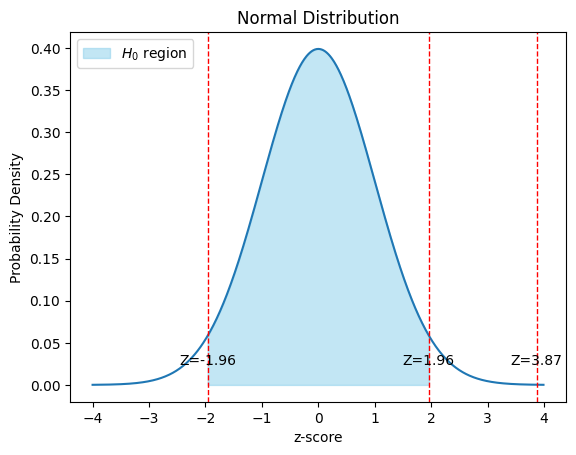

In [ ]:
mu = 1500
z_score = (sample_mean - mu) / (pop_sd / np.sqrt(sample_size))
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
print(f"Z-score: {z_score}")
print(f"P-value: {p_value}")



ax = plt.subplots(1, 1)
x_axis = np.arange(-4, 4, 0.01)
y_axis = stats.norm.pdf(x_axis, 0, 1)

plt.plot(x_axis, y_axis)

z_marks = [-1.96, 1.96, z_score]
for z in z_marks:
    plt.axvline(x=z, color='r', linestyle='--', linewidth=1)
    plt.text(z, 0.02, f'Z={round(z, 2)}', ha='center', va='bottom')

z_fill_left = -1.96
z_fill_right = 1.96
x_fill = np.linspace(z_fill_left, z_fill_right, 100)
y_fill = stats.norm.pdf(x_fill)
plt.fill_between(x_fill, y_fill, color='skyblue', alpha=0.5, label=f'$H_0$ region')
plt.legend()

plt.title('Normal Distribution')
plt.xlabel('z-score')
plt.ylabel('Probability Density')

plt.show()


Conclusion: Since the p-value is less than $\alpha$ 0.05, we reject the null hypothesis. This suggests that the average Fair Market Rent for a 1-bedroom unit in 2021 is significantly different from $1500.